In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import warnings
import spacy
import torch.nn as nn
from anchor import anchor_text
import pickle
from myUtils import *
from transformer.utils import *
from dataset.dataset_loader import *
import transformer.training as training
import transformer.plot as plot
import pandas as pd
import sys

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")

In [2]:
plt.rcParams['font.size'] = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
review_parser, label_parser, ds_train, ds_valid, ds_test = create_sentiment_dataset()

Number of tokens in training samples: 3307
Number of tokens in training labels: 2


In [6]:
anchor_examples = pickle.load( open( "results/transformer_anchor_examples.pickle", "rb" ))
explanations = pickle.load(open( "results/gru_extended_counter_exps.pickle", "rb" ))
#explanations = [exp for exp in explanations if len(exp.fit_examples) > 100] 
#explanations.sort(key=lambda exp: exp.test_precision)

In [32]:
def generate_example(ds, anchor_examples, explanations):
    filtered_examples = []
    for example in ds:
        for exp in explanations:     
            if ' '.join(example.text)==anchor_examples[exp.index]:
                if exp.test_precision < 0.5:
                    example.label = 0
                else:
                     example.label = 1
                filtered_examples.append(example)
                
                break
                
    return filtered_examples

In [33]:
examples = generate_example(ds_train, anchor_examples, explanations)

In [34]:
size = len(examples)
train_size = round(0.75*size)
train_examples = examples[:train_size]
valid_examples = examples[train_size:]

In [35]:
def save_to_csv(examples, name):
    text = [' '.join(example.text) for example in examples]
    label = [example.label for example in examples]
    pd.DataFrame({'review': text, 'label': label}).to_csv(f'dataset/hugging/{name}.csv')

In [36]:
save_to_csv(train_examples, 'train')
save_to_csv(valid_examples, 'dev')

In [37]:
from transformer.huggingUtils import *
set_seed()
model = load_model('roberta-base')
data = load_data('dataset/hugging', 'dataset/hugging')
tokenized_data = tokenize_dataset(data, tokenizer_name='roberta-base')
train(model, tokenized_data)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /home/almr16/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/almr16/.cache/huggingface/datasets/csv/default-99bbc69dae4af3ac/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /home/almr16/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 1,
  "u

  0%|          | 0/287 [00:00<?, ?ex/s]

  0%|          | 0/96 [00:00<?, ?ex/s]

PyTorch: setting up devices
***** Running training *****
  Num examples = 287
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 90


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.617206,0.687500
2,No log,0.602882,0.687500
3,No log,0.562430,0.687500
4,No log,0.808213,0.687500
5,No log,0.848875,0.718750
6,No log,0.731736,0.729167
7,No log,0.935281,0.708333
8,No log,1.123646,0.687500
9,No log,1.169621,0.708333
10,No log,1.226919,0.708333


***** Running Evaluation *****
  Num examples = 96
  Batch size = 32
***** Running Evaluation *****
  Num examples = 96
  Batch size = 32
***** Running Evaluation *****
  Num examples = 96
  Batch size = 32
***** Running Evaluation *****
  Num examples = 96
  Batch size = 32
***** Running Evaluation *****
  Num examples = 96
  Batch size = 32
***** Running Evaluation *****
  Num examples = 96
  Batch size = 32
***** Running Evaluation *****
  Num examples = 96
  Batch size = 32
***** Running Evaluation *****
  Num examples = 96
  Batch size = 32
***** Running Evaluation *****
  Num examples = 96
  Batch size = 32
***** Running Evaluation *****
  Num examples = 96
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=90, training_loss=0.29668689303927953, metrics={'train_runtime': 24.3027, 'train_samples_per_second': 118.094, 'train_steps_per_second': 3.703, 'total_flos': 188782182220800.0, 'train_loss': 0.29668689303927953, 'epoch': 10.0})

In [10]:
ds_train.examples = train_examples
ds_valid.examples = valid_examples
ds_test = ds_valid

In [11]:
import tqdm
import sys
def forward_dl(model, dl, device, type_dl):
    model.train(False)
    num_samples = len(dl) * dl.batch_size
    num_batches = len(dl)  
    pbar_name = type(model).__name__
    list_y_real = []
    list_y_pred = []
    pbar_file = sys.stdout
    num_correct = 0
    dl_iter = iter(dl)
    for batch_idx in range(num_batches):
        data = next(dl_iter)
        x, y = data.text, data.label
        list_y_real.append(y)
        x = x.to(device)  # (S, B, E)
        y = y.to(device)  # (B,)
        with torch.no_grad():
            if isinstance(model, models.VanillaGRU):
                y_pred_log_proba = model(x)
            elif isinstance(model, models.MultiHeadAttentionNet):
                y_pred_log_proba, _ = model(x)
            y_pred = torch.argmax(y_pred_log_proba, dim=1)
            num_correct += torch.sum(y_pred == y).float().item()
            list_y_pred.append(y_pred)
    accuracy = 100.0 * num_correct / num_samples
    print(f'Accuracy for {type_dl} is {accuracy}')
    
    all_y_real = torch.cat(list_y_real)
    all_y_pred = torch.cat(list_y_pred)
    return all_y_real, all_y_pred, accuracy

In [12]:
def get_classes_for_csv():
    classes = None
    if type_dataset == 'trinary':
        classes = ['positive', 'negative', 'neutral']
    elif type_dataset == 'binary':
        classes = ['positive', 'negative']
    elif type_dataset == 'fine_grained':
        classes = ['positive', 'negative', 'neutral', 'very_positive', 'very_negative']
    index_csv = [f'pred_{curr_class}' for curr_class in classes]
    columns_csv = [f'real_{curr_class}' for curr_class in classes]
    return classes, index_csv, columns_csv

In [13]:
import pandas as pd

def compute_confusion_matrix(y_real, y_pred, model_name, type_dl):
    classes, index_csv, columns_csv = get_classes_for_csv()
    num_classes = len(classes)
    num_classes_in_y = len(torch.unique(y_real))
    assert num_classes == num_classes_in_y, 'Mismatch in number of classes'
    confusion_matrix = torch.zeros(num_classes, num_classes)
    for class_index, class_name in enumerate(classes):
            all_pred_classes = y_pred[y_real == class_index]
            curr_col = torch.histc(all_pred_classes, bins=num_classes, min=0, max=num_classes - 1)
            confusion_matrix[:, class_index] = curr_col
    confusion_matrix = confusion_matrix.numpy()
    df = pd.DataFrame(confusion_matrix, index = index_csv, columns = columns_csv, dtype=int)
    #df.to_csv(output_directory / str('confusion_matrix_' + model_name + '_' + type_dl + '.csv'))
    return df

In [14]:
import torch.optim as optim
import numpy as np
import pandas as pd
from pathlib import Path
def train_model(model_name, device, output_directory = 'results'):
    NUM_EPOCHS = 100
    if model_name == 'gru':
        hp = load_hyperparams(model_name, type_dataset)
        model = models.VanillaGRU(review_parser.vocab, hp['embedding_dim'], hp['hidden_dim'], hp['num_layers'], hp['output_classes'], hp['dropout']).to(device)
    elif model_name == 'attention':
        hp = load_hyperparams(model_name, type_dataset)
        model = models.MultiHeadAttentionNet(input_vocabulary=review_parser.vocab, embed_dim=hp['embedding_dim'], num_heads=hp['num_heads'], 
                                           dropout=hp['dropout'], two_attention_layers=hp['two_atten_layers'], output_classes=hp['output_classes']).to(device)
    print(model)
    dl_train, dl_valid, dl_test = torchtext.legacy.data.BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size=hp['batch_size'], sort = False, shuffle=True, device=device)

    optimizer = optim.Adam(model.parameters(), lr=hp['lr'])
    loss_fn = nn.NLLLoss()
    
    trainer = training.SentimentTrainer(model, loss_fn, optimizer, device)
    checkpoint_filename = str(output_directory) +  '/' + model_name
    print(f'Saving checkpoint with prefix: {checkpoint_filename}')
    fit_res = trainer.fit(dl_train, dl_valid, NUM_EPOCHS, early_stopping = hp['early_stopping'], checkpoints = checkpoint_filename, params = hp)

    fig, axes = plot.plot_fit(fit_res)
    fig.savefig(output_directory + '/' + str(model_name + '.png'))
    saved_state = torch.load(checkpoint_filename + '.pt', map_location=device)
    model.load_state_dict(saved_state["model_state"])
    loaded_hp = saved_state["parameters"]
    print('----- Loaded params ------')
    print(loaded_hp)
    all_dataloaders = [dl_train, dl_valid, dl_test]
    type_dls = ['train', 'valid', 'test']
    accuracies = []
    for dl, type_dl in zip(all_dataloaders, type_dls):
        y_real, y_pred, accuracy = forward_dl(model, dl, device, type_dl)
        df = compute_confusion_matrix(y_real, y_pred, model_name, type_dl)
        accuracies.append(accuracy)
        display(df)
    numpy_accuracy = np.array(accuracies)
    df = pd.DataFrame(numpy_accuracy, index = type_dls, dtype=float)
    df.to_csv(output_directory + '/' + str('accuracies_' + model_name + '.csv')) 

{'embedding_dim': 100, 'batch_size': 32, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.0005, 'early_stopping': 8, 'output_classes': 2}
VanillaGRU(
  (embedding_layer): Embedding(3307, 100)
  (GRU_layer): GRU(100, 256, num_layers=2, dropout=0.3)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)
Saving checkpoint with prefix: results/gru
*** Loading checkpoint file results/gru.pt
--- EPOCH 1/100 ---
train_batch (Avg. Loss 0.593, Accuracy 71.6): 100%|█| 12/12 [00:00<00:00, 128.33
test_batch (Avg. Loss 0.550, Accuracy 74.2): 100%|█| 4/4 [00:00<00:00, 394.97it/
--- EPOCH 2/100 ---
train_batch (Avg. Loss 0.594, Accuracy 71.6): 100%|█| 12/12 [00:00<00:00, 164.67
test_batch (Avg. Loss 0.556, Accuracy 74.2): 100%|█| 4/4 [00:00<00:00, 377.74it/
--- EPOCH 3/100 ---
train_batch (Avg. Loss 0.575, Accuracy 71.6): 100%|█| 12/12 [00:00<00:00, 164.06
test_batch (Avg. Loss 0.537, Accuracy 74.2): 

,real_positive,real_negative
pred_positive,0,0
pred_negative,108,275


Accuracy for valid is 74.21875


,real_positive,real_negative
pred_positive,0,0
pred_negative,33,95


Accuracy for test is 74.21875


,real_positive,real_negative
pred_positive,0,0
pred_negative,33,95


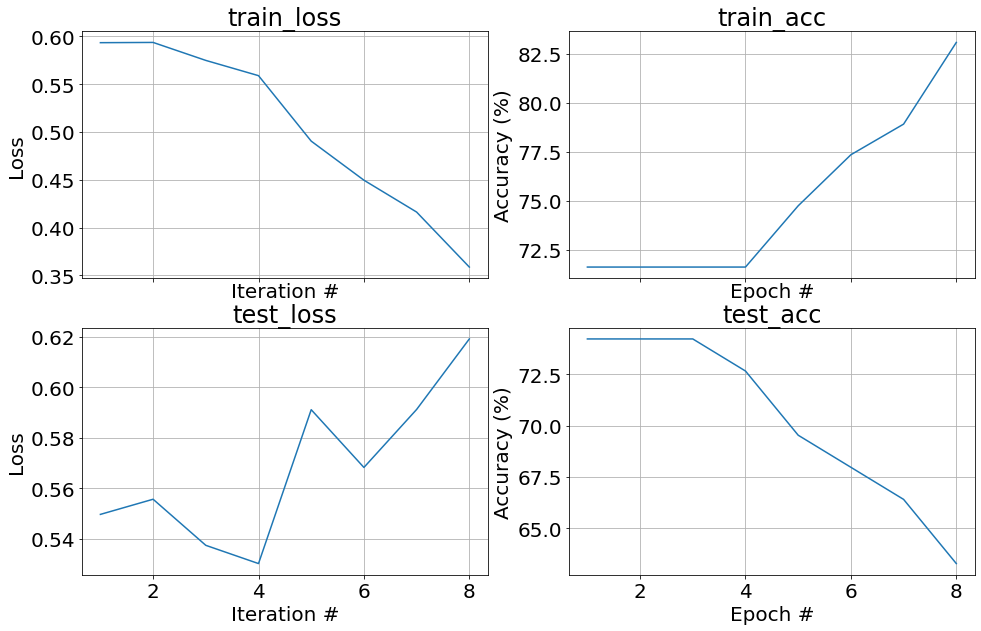

In [15]:
SEED = 84
torch.manual_seed(SEED)
train_model('gru', device)